<a href="https://colab.research.google.com/github/heraclex12/FER-ResidualMaskingNetwork/blob/master/FER2013_baseline_and_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras

In [ ]:
from keras.initializers import glorot_uniform
from keras.layers import Input, ZeroPadding2D, Add, GlobalAveragePooling2D, Concatenate
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Dropout, Dense, AveragePooling2D, Lambda
from keras.models import Sequential, Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.utils.data_utils import get_file
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings 
import tensorflow as tf
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### LOAD DATA

In [ ]:
training_set = pd.read_csv("drive/My Drive/fer2013_data/train.csv")
test_set = pd.read_csv("drive/My Drive/fer2013_data/test.csv")
validation_set = pd.read_csv("drive/My Drive/fer2013_data/val.csv")

In [ ]:
training_labels = to_categorical(training_set['emotion'])
test_labels = to_categorical(test_set['emotion'])
validation_labels = to_categorical(validation_set['emotion'])

In [ ]:
training_pixels = training_set['pixels'].str.split().tolist()
training_pixels = np.array(training_pixels)
training_pixels = training_pixels.reshape(-1, 48, 48, 1)
training_pixels = training_pixels.astype(np.float32) / 255
training_pixels = np.repeat(training_pixels, 3, -1)        # convert to 3channels


test_pixels = test_set['pixels'].str.split().tolist()
test_pixels = np.array(test_pixels)
test_pixels = test_pixels.reshape(-1, 48, 48, 1)
test_pixels = test_pixels.astype(np.float32) / 255
test_pixels = np.repeat(test_pixels, 3, -1)        # convert to 3channels


validation_pixels = validation_set['pixels'].str.split().tolist()
validation_pixels = np.array(validation_pixels)
validation_pixels = validation_pixels.reshape(-1, 48, 48, 1)
validation_pixels = validation_pixels.astype(np.float32) / 255
validation_pixels = np.repeat(validation_pixels, 3, -1)        # convert to 3channels


In [ ]:
print(training_pixels.shape)
print(test_pixels.shape)
print(validation_pixels.shape)

print(training_labels.shape)
print(test_labels.shape)
print(validation_labels.shape)

(28709, 48, 48, 3)
(3589, 48, 48, 3)
(3589, 48, 48, 3)
(28709, 7)
(3589, 7)
(3589, 7)


### Visualize face images

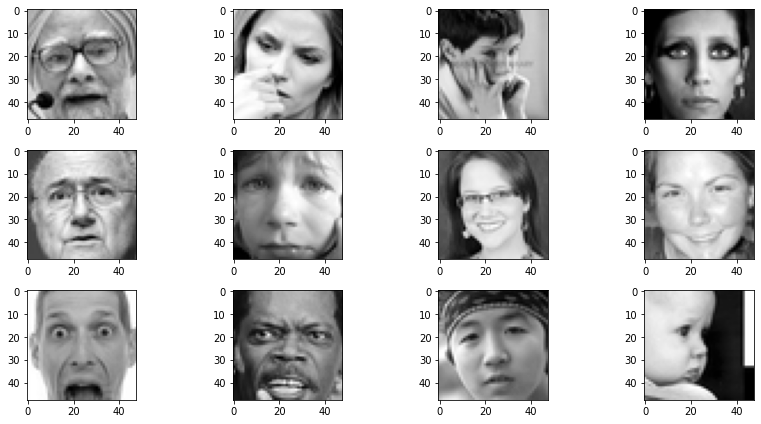

In [ ]:
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
  plt.subplot(3, 4, i)
  plt.imshow(training_pixels[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
# Create model

basic_model = Sequential()

basic_model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48, 48, 1)))
basic_model.add(MaxPooling2D(pool_size=(5,5), strides=(2,2)))

basic_model.add(Conv2D(64, (3, 3), activation='relu'))
basic_model.add(Conv2D(64, (3, 3), activation='relu'))
basic_model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

# Flatten layer
basic_model.add(Flatten())

# Fully-connected layers
basic_model.add(Dense(1024, activation='relu'))
basic_model.add(Dropout(0.2))
basic_model.add(Dense(1024, activation='relu'))
basic_model.add(Dropout(0.2))

# output layer
basic_model.add(Dense(7, activation='softmax'))

## Baseline

In [ ]:
# Model obtain 64% (CNNs)

more_complex_model = Sequential()

more_complex_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 3),
                              kernel_regularizer=l2(0.01)))
more_complex_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
more_complex_model.add(BatchNormalization())
more_complex_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
more_complex_model.add(Dropout(0.5))

more_complex_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
more_complex_model.add(BatchNormalization())
more_complex_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
more_complex_model.add(BatchNormalization())
more_complex_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
more_complex_model.add(Dropout(0.5))

more_complex_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
more_complex_model.add(BatchNormalization())
more_complex_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
more_complex_model.add(BatchNormalization())
more_complex_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
more_complex_model.add(Dropout(0.5))

more_complex_model.add(Flatten())

more_complex_model.add(Dense(512, activation='relu'))
more_complex_model.add(Dropout(0.4))
more_complex_model.add(Dense(256, activation='relu'))
more_complex_model.add(Dropout(0.4))
more_complex_model.add(Dense(128, activation='relu'))
more_complex_model.add(Dropout(0.5))

more_complex_model.add(Dense(7, activation='softmax'))

In [ ]:
more_complex_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 128)      

In [ ]:
# callbacks

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)

early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

tensorBoard = TensorBoard(log_dir='drive/My Drive/fer2013_data/logs')

checkpointer = ModelCheckpoint("drive/My Drive/fer2013_data/models/model.h5", monitor='val_accuracy', verbose=1, save_best_only=True)

In [ ]:
# CNNs training

more_complex_model.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=["accuracy"])

classifier = more_complex_model.fit(training_pixels, training_labels, batch_size = 64, epochs=100, 
                             validation_data= (validation_pixels, validation_labels), callbacks=[lr_reducer, early_stopper])

more_complex_model.load_weights("drive/My Drive/fer2013_data/models/model.h5")
score, acc = more_complex_model.evaluate(test_pixels, test_labels, verbose=0)
print("Accuracy:", acc)
print("Score:", score)

Train on 28709 samples, validate on 3589 samples
Epoch 1/100
28709/28709 [==============================] - 86s 3ms/step - loss: 2.0787 - accuracy: 0.2121 - val_loss: 1.8493 - val_accuracy: 0.2502
Epoch 2/100
28709/28709 [==============================] - 77s 3ms/step - loss: 1.8478 - accuracy: 0.2458 - val_loss: 1.7989 - val_accuracy: 0.2494
Epoch 3/100
28709/28709 [==============================] - 77s 3ms/step - loss: 1.7958 - accuracy: 0.2705 - val_loss: 1.7836 - val_accuracy: 0.2664
Epoch 4/100
28709/28709 [==============================] - 77s 3ms/step - loss: 1.7206 - accuracy: 0.3117 - val_loss: 1.6494 - val_accuracy: 0.3369
Epoch 5/100
28709/28709 [==============================] - 77s 3ms/step - loss: 1.6356 - accuracy: 0.3491 - val_loss: 1.7479 - val_accuracy: 0.2931
Epoch 6/100
28709/28709 [==============================] - 77s 3ms/step - loss: 1.5596 - accuracy: 0.3860 - val_loss: 1.5625 - val_accuracy: 0.3982
Epoch 7/100
28709/28709 [==============================] - 77s 

## Residual Network 50 and 152

In [ ]:
def identity_block(X, f, filters, stage, block):
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  F1, F2, F3 = filters
  X_shortcut = X
  
  X = Conv2D(filters = F1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
             name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0), bias=False)(X)
  X = BatchNormalization(axis = 3, name=bn_name_base + '2a')(X)
  X = Activation('relu', name=conv_name_base + '2a_relu')(X)

  X = Conv2D(filters=F2, kernel_size = (f, f), strides=(1, 1), padding='same',
             name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0), bias=False)(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
  X = Activation('relu', name=conv_name_base + '2b_relu')(X)

  X = Conv2D(filters=F3, kernel_size= (1, 1), strides=(1, 1), padding='valid',
             name = conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0), bias=False)(X)
  X = BatchNormalization(axis = 3, name=bn_name_base + '2c')(X)

  X = Add()([X, X_shortcut])
  X = Activation('relu', name='res' + str(stage) + block + '_relu')(X)

  return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s= 2):
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  F1, F2, F3 = filters

  X_shortcut = X

  X = Conv2D(F1, (1, 1), strides=(s, s), name = conv_name_base + '2a', padding='valid',
             kernel_initializer=glorot_uniform(seed=0), bias=False)(X)
  X = BatchNormalization(axis = 3, name=bn_name_base + '2a')(X)
  X = Activation('relu', name=conv_name_base + '2a_relu')(X)

  X = Conv2D(F2, (f, f), strides=(1, 1), name=conv_name_base + '2b', padding='same',
             kernel_initializer=glorot_uniform(seed=0), bias=False)(X)
  X = BatchNormalization(axis = 3, name=bn_name_base + '2b')(X)
  X = Activation('relu', name=conv_name_base + '2b_relu')(X)

  X = Conv2D(F3, (1, 1), strides=(1, 1), name = conv_name_base + '2c', padding='valid',
             kernel_initializer=glorot_uniform(seed=0), bias=False)(X)
  X = BatchNormalization(axis = 3, name=bn_name_base + '2c')(X)

  X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), name = conv_name_base + '1',
                      padding='valid', kernel_initializer=glorot_uniform(seed=0), bias=False)(X_shortcut)
  X_shortcut = BatchNormalization(axis = 3, name=bn_name_base + '1')(X_shortcut)

  X = Add()([X, X_shortcut])
  X = Activation('relu', name='res' + str(stage) + block + '_relu')(X)
  return X

In [ ]:
def ResNet152(input_shape=(48, 48, 1), classes = 7):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    

    X = Lambda(lambda img : tf.image.resize(img, (224, 224)))(X_input)
    # Zero-Padding
    X = ZeroPadding2D((3, 3), name='conv1_zeropadding')(X)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', bias=False, kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu', name='conv1_relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b1')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b2')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b3')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b4')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b5')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b6')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b7')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b1')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b2')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b3')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b4')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b5')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b6')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b7')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b8')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b9')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b10')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b11')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b12')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b13')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b14')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b15')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b16')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b17')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b18')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b19')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b20')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b21')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b22')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b23')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b24')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b25')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b26')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b27')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b28')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b29')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b30')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b31')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b32')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b33')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b34')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b35')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), padding='same', name='avg_pool')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet152')
    
    model.load_weights("drive/My Drive/fer2013_data/models/resnet152_weights_tf.h5", by_name=True)

    return model

In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
model = ResNet152(input_shape=(48, 48, 3), classes=7)

for layer in model.layers[:-1]:
  layer.trainable = False

model.compile(optimizer=SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(aug.flow(training_pixels, training_labels, 48), steps_per_epoch=len(training_pixels) // 48, epochs=15, 
                             validation_data= (validation_pixels, validation_labels),  callbacks=[checkpointer])


Epoch 1/15
599/598 [==============================] - 197s 328ms/step - loss: 232.3114 - accuracy: 0.2090 - val_loss: 33170237.5085 - val_accuracy: 0.1382

Epoch 00001: val_accuracy improved from -inf to 0.13820, saving model to drive/My Drive/fer2013_data/models/model.h5
Epoch 2/15
599/598 [==============================] - 181s 302ms/step - loss: 197.8680 - accuracy: 0.2264 - val_loss: 23790197.6133 - val_accuracy: 0.2494

Epoch 00002: val_accuracy improved from 0.13820 to 0.24937, saving model to drive/My Drive/fer2013_data/models/model.h5
Epoch 3/15
599/598 [==============================] - 181s 302ms/step - loss: 192.4505 - accuracy: 0.2304 - val_loss: 19265404.1259 - val_accuracy: 0.2494

Epoch 00003: val_accuracy did not improve from 0.24937
Epoch 4/15
599/598 [==============================] - 181s 302ms/step - loss: 185.7786 - accuracy: 0.2332 - val_loss: 9226116.2087 - val_accuracy: 0.1298

Epoch 00004: val_accuracy did not improve from 0.24937
Epoch 5/15
599/598 [==========

In [ ]:
 for layer in model.layers:
  layer.trainable = True

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
model.compile(optimizer=SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(aug.flow(training_pixels, training_labels, 48), steps_per_epoch=len(training_pixels) / 48, epochs=50, 
                             validation_data= (validation_pixels, validation_labels),  callbacks=[lr_reducer, checkpointer])

model.load_weights("drive/My Drive/fer2013_data/models/model.h5")
score, acc = model.evaluate(test_pixels, test_labels, verbose=0)
print("Accuracy:", acc)
print("Score:", score)

Epoch 1/50
599/598 [==============================] - 704s 1s/step - loss: 30.1799 - accuracy: 0.2197 - val_loss: 4.1205 - val_accuracy: 0.2594

Epoch 00001: val_accuracy improved from 0.24937 to 0.25940, saving model to drive/My Drive/fer2013_data/models/model.h5
Epoch 2/50
599/598 [==============================] - 654s 1s/step - loss: 3.8105 - accuracy: 0.2423 - val_loss: 12.4495 - val_accuracy: 0.2722

Epoch 00002: val_accuracy improved from 0.25940 to 0.27222, saving model to drive/My Drive/fer2013_data/models/model.h5
Epoch 3/50
599/598 [==============================] - 653s 1s/step - loss: 2.2934 - accuracy: 0.2508 - val_loss: 4.4445 - val_accuracy: 0.2878

Epoch 00003: val_accuracy improved from 0.27222 to 0.28782, saving model to drive/My Drive/fer2013_data/models/model.h5
Epoch 4/50
599/598 [==============================] - 654s 1s/step - loss: 1.9788 - accuracy: 0.2600 - val_loss: 4.5170 - val_accuracy: 0.2797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.008